# Notebook Overview

This notebook performs data preprocessing and feature selection on the NF-ToN-IoT-v2 dataset. The steps are as follows:


1. **Importing Libraries and Loading Data**:
    - Import necessary libraries such as pandas and warnings.
    - Load the dataset from a CSV file.

In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

ton_iot = pd.read_csv('NF-ToN-IoT-v2.csv')


2. **Feature Deletion**:
    - Define lists of features to be deleted based on different criteria such as categorical features, unused features, target features, and features to be dropped due to high correlation or high variance inflation factor (VIF).
    - Drop the specified features from the dataset.

### Deletes features from 

In [2]:
categorical_feature = ['L4_SRC_PORT','L4_DST_PORT','IPV4_SRC_ADDR',
                       'IPV4_DST_ADDR','PROTOCOL',
                       'L7_PROTO','DNS_QUERY_TYPE','ICMP_TYPE'
                        ,'ICMP_IPV4_TYPE','DNS_TTL_ANSWER']


not_used = ['DNS_QUERY_ID','FTP_COMMAND_RET_CODE']

tagets = ['Attack','Label']

to_drop_corr_col = ['SERVER_TCP_FLAGS', 'MAX_TTL', 'MAX_IP_PKT_LEN', 'RETRANSMITTED_OUT_PKTS']

to_drop_VIF = ['NUM_PKTS_1024_TO_1514_BYTES', 'CLIENT_TCP_FLAGS']

#to_drop = categorical_feature+not_used+tagets + to_drop_corr_col + to_drop_VIF

#X_Numerical = ton_iot.drop(columns=to_drop)

to_drop = not_used+tagets + to_drop_corr_col + to_drop_VIF

X = ton_iot.drop(columns=to_drop)


In [3]:
X['SRC_TO_DST_SECOND_BYTES'] = X['SRC_TO_DST_SECOND_BYTES'].astype(int)
X['DST_TO_SRC_SECOND_BYTES'] = X['DST_TO_SRC_SECOND_BYTES'].astype(int)

y_b = ton_iot['Label']


In [4]:
X.shape

(16940496, 35)

## Scaling of Numerical value using  quantile

In [5]:
from sklearn.model_selection import train_test_split



X_train, X, y_train, y_b = train_test_split(X, y_b, test_size=0.1, random_state=42)



In [6]:
del ton_iot
del X_train
del y_train


In [7]:
X = X.reset_index()
y_b = y_b.reset_index()


In [8]:

X = X.drop(columns='index')
y_b = y_b.drop(columns='index')

In [9]:
X_Numerical = X.drop(columns=categorical_feature)

In [10]:
X_Numerical.head(4)

,IN_BYTES,IN_PKTS,OUT_BYTES,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,DURATION_IN,DURATION_OUT,MIN_TTL,LONGEST_FLOW_PKT,...,RETRANSMITTED_IN_PKTS,RETRANSMITTED_OUT_BYTES,SRC_TO_DST_AVG_THROUGHPUT,DST_TO_SRC_AVG_THROUGHPUT,NUM_PKTS_UP_TO_128_BYTES,NUM_PKTS_128_TO_256_BYTES,NUM_PKTS_256_TO_512_BYTES,NUM_PKTS_512_TO_1024_BYTES,TCP_WIN_MAX_IN,TCP_WIN_MAX_OUT
0,661,10,2234,8,27,4294733,234,234,64,1500,...,0,0,16000,72000,15,0,2,0,29200,65535
1,112,2,112,2,19,4294904,0,63,64,60,...,0,0,896000,8000,4,0,0,0,29200,28960
2,48,1,0,0,2,0,0,0,0,48,...,0,0,384000,0,1,0,0,0,4096,0
3,4106,8,2132,7,27,0,0,0,64,1500,...,0,0,32848000,17056000,10,0,1,1,29200,26847


In [11]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_Numerical_sc = pd.DataFrame()

scaler.fit(X_Numerical)

X_Numerical_sc[X_Numerical.columns] = scaler.transform(X_Numerical)

In [12]:
X_Numerical_sc.shape

(1694050, 25)

In [13]:
y_b.head(2)

,Label
0,1
1,1


In [14]:
print('Numerical')
print(25*0.8)
print(25*0.5)
print(25*0.2)
print('categorical')
print(10*0.8)
print(10*0.5)
print(10*0.2)

Numerical
20.0
12.5
5.0
categorical
8.0
5.0
2.0


## Scale data

In [15]:
from sklearn.feature_selection import f_classif, SelectKBest

sb = SelectKBest(f_classif, k=5)
sb.fit(X_Numerical_sc,y_b)
col_anova_20 = sb.get_feature_names_out()

##########################
sb = SelectKBest(f_classif, k=10)
sb.fit(X_Numerical_sc,y_b)
col_anova_40 = sb.get_feature_names_out()

##########################
sb = SelectKBest(f_classif, k=15)
sb.fit(X_Numerical_sc,y_b)
col_anova_60 = sb.get_feature_names_out()

In [16]:
sb.get_support()

array([False, False, False, False,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True, False, False, False,  True,
        True,  True, False, False, False,  True,  True])

In [17]:
X_A_20 = X_Numerical_sc[col_anova_20]
X_A_40 = X_Numerical_sc[col_anova_40]
X_A_60 = X_Numerical_sc[col_anova_60]

In [18]:
X_cat = X[categorical_feature]

# Optimize the features

### L4_SRC_PORT & L4_DST_PORT

Ports with numbers 0–1023 are called system or well-known ports; ports with numbers 1024-49151 are called user or registered ports, and ports with numbers 49152-65535 are called dynamic, private or ephemeral ports.[2] Both system and user ports are used by transport protocols (TCP, UDP, DCCP, SCTP) to identify an application or service.

In [19]:
well_known_port = list(range(1024))
registered_ports = list(range(1024,49152))
ephemeral_ports = list(range(49152,65535))

In [20]:
X_cat['L4_SRC_PORT_C'] = 'Others'
X_cat['L4_SRC_PORT_C'][X_cat['L4_SRC_PORT'].isin(well_known_port)] = 'well_known_port'
X_cat['L4_SRC_PORT_C'][X_cat['L4_SRC_PORT'].isin(registered_ports)] = 'registered_ports'
X_cat['L4_SRC_PORT_C'][X_cat['L4_SRC_PORT'].isin(ephemeral_ports)] = 'ephemeral_ports'

X_cat.drop(columns=['L4_SRC_PORT'],inplace=True)

X_cat['L4_SRC_PORT_C'].value_counts()

print(X_cat.shape)

(1694050, 10)


In [21]:
X_cat['L4_DST_PORT_C'] = 'Others'
X_cat['L4_DST_PORT_C'][X_cat['L4_DST_PORT'].isin(well_known_port)] = 'well_known_port'
X_cat['L4_DST_PORT_C'][X_cat['L4_DST_PORT'].isin(registered_ports)] = 'registered_ports'
X_cat['L4_DST_PORT_C'][X_cat['L4_DST_PORT'].isin(ephemeral_ports)] = 'ephemeral_ports'

X_cat.drop(columns=['L4_DST_PORT'],inplace=True)
X_cat['L4_DST_PORT_C'].value_counts()


well_known_port     923533
registered_ports    653980
ephemeral_ports     116531
Others                   6
Name: L4_DST_PORT_C, dtype: int64

#### Removerd features are :

to_drop_zero = ['RETRANSMITTED_IN_BYTES','RETRANSMITTED_IN_PKTS','RETRANSMITTED_OUT_BYTES','FTP_COMMAND_RET_CODE','ICMP_TYPE','DNS_TTL_ANSWER']
&&

['SERVER_TCP_FLAGS', 'MAX_TTL', 'MAX_IP_PKT_LEN', 'RETRANSMITTED_OUT_PKTS', 'ICMP_IPV4_TYPE']

## DNS

In [22]:
X_cat['DNS_QUERY_TYPE'] = X_cat['DNS_QUERY_TYPE'].astype('O')
list_proto = [0,1,2,12]
X_cat['DNS_QUERY_TYPE'][~X_cat['DNS_QUERY_TYPE'].isin(list_proto)] = 'Other'
X_cat['DNS_QUERY_TYPE'].value_counts()

0        1454488
1         156701
Other      74277
12          8105
2            479
Name: DNS_QUERY_TYPE, dtype: int64

### PROTOCOL

In [23]:
X_cat['PROTOCOL'] = X_cat['PROTOCOL'].astype(int)

X_cat['PROTOCOL'].value_counts()

6     1443022
17     248755
1        1864
2         282
58        126
44          1
Name: PROTOCOL, dtype: int64

In [24]:
print(X_cat.shape)

(1694050, 10)


In [25]:
X_cat['PROTOCOL'].value_counts()

6     1443022
17     248755
1        1864
2         282
58        126
44          1
Name: PROTOCOL, dtype: int64

### L7_PROTO

In [26]:
X_cat['L7_PROTO'] = X_cat['L7_PROTO'].astype('O')
list_proto = [0,7,91,7.178,1,92,131,5.178]
X_cat['L7_PROTO'][~X_cat['L7_PROTO'].isin(list_proto)] = 'Other'
X_cat['L7_PROTO'].value_counts()

0.0      1028224
7.0       400678
91.0      173755
Other      48772
7.178      19971
1.0        13031
92.0        3793
131.0       3020
5.178       2806
Name: L7_PROTO, dtype: int64

#### Adresses

### Adress Range

In [27]:
# Private adresses
# Class A: 10.0.0.0 to 10.255.255.255
# Class B: 172.16.0.0 to 172.31.255.255
# Class C: 192.168.0.0 to 192.168.255.255
from ipaddress import ip_address


def findIPs(start, end):
    start = ip_address(start)
    end = ip_address(end)
    result = []
    while start <= end:
        result.append(str(start))
        start += 1
    return result
print('classe_a process ------------------------------->')
plage_classe_a=findIPs('10.0.0.0', '10.255.255.255')
print('classe_b process ------------------------------->')
plage_classe_b=findIPs('172.16.0.0', '172.31.255.255')
print('classe_c process ------------------------------->')
plage_classe_c=findIPs('192.168.0.0', '192.168.255.255')

classe_a process ------------------------------->
classe_b process ------------------------------->
classe_c process ------------------------------->


In [28]:
import numpy as np
X_cat['IPV4_DST_ADDR_CLASSE'] = 'None'
print('classe_c process ------------------------------->')
X_cat['IPV4_DST_ADDR_CLASSE'][X_cat['IPV4_DST_ADDR'].isin(plage_classe_c)] = 'classe_c'
print('classe_b process ------------------------------->')
X_cat['IPV4_DST_ADDR_CLASSE'][X_cat['IPV4_DST_ADDR'].isin(plage_classe_b)] = 'classe_b'
print('classe_a process ------------------------------->')
X_cat['IPV4_DST_ADDR_CLASSE'][X_cat['IPV4_DST_ADDR'].isin(plage_classe_a)] = 'classe_a'
print('localhost process ------------------------------->')
X_cat['IPV4_DST_ADDR_CLASSE'][X_cat['IPV4_DST_ADDR'] == '127.0.0.1'] = 'localhost'
print('public/other process ------------------------------->')
X_cat['IPV4_DST_ADDR_CLASSE'][X_cat['IPV4_DST_ADDR_CLASSE'] == 'None'] = 'public/other'
X_cat['IPV4_DST_ADDR_CLASSE'].value_counts()

classe_c process ------------------------------->
classe_b process ------------------------------->
classe_a process ------------------------------->
localhost process ------------------------------->
public/other process ------------------------------->


classe_c        1600718
public/other      92888
localhost           442
classe_a              1
classe_b              1
Name: IPV4_DST_ADDR_CLASSE, dtype: int64

In [29]:
import numpy as np
X_cat['IPV4_SRC_ADDR_CLASSE'] = 'None'
print('classe_c process ------------------------------->')
X_cat['IPV4_SRC_ADDR_CLASSE'][X_cat['IPV4_SRC_ADDR'].isin(plage_classe_c)] = 'classe_c'
print('classe_b process ------------------------------->')
X_cat['IPV4_SRC_ADDR_CLASSE'][X_cat['IPV4_SRC_ADDR'].isin(plage_classe_b)] = 'classe_b'
print('classe_a process ------------------------------->')
X_cat['IPV4_SRC_ADDR_CLASSE'][X_cat['IPV4_SRC_ADDR'].isin(plage_classe_a)] = 'classe_a'
print('localhost process ------------------------------->')
X_cat['IPV4_SRC_ADDR_CLASSE'][X_cat['IPV4_SRC_ADDR'] == '127.0.0.1'] = 'localhost'
print('public/other process ------------------------------->')
X_cat['IPV4_SRC_ADDR_CLASSE'][X_cat['IPV4_SRC_ADDR_CLASSE'] == 'None'] = 'public/other'
X_cat['IPV4_SRC_ADDR_CLASSE'].value_counts()

classe_c process ------------------------------->
classe_b process ------------------------------->
classe_a process ------------------------------->
localhost process ------------------------------->
public/other process ------------------------------->


classe_c        1678881
classe_b          10354
public/other       4360
localhost           443
classe_a             12
Name: IPV4_SRC_ADDR_CLASSE, dtype: int64

Remove IPV4_SRC_ADDR & IPV4_DST_ADDR and Keep IPV4_SRC_ADDR IPV4_DST_ADDR

In [30]:
X_cat.drop(columns=['IPV4_SRC_ADDR','IPV4_DST_ADDR'], inplace=True)
X.drop(columns=['IPV4_SRC_ADDR','IPV4_DST_ADDR'], inplace=True)

In [31]:
X_cat.head(2)

,PROTOCOL,L7_PROTO,DNS_QUERY_TYPE,ICMP_TYPE,ICMP_IPV4_TYPE,DNS_TTL_ANSWER,L4_SRC_PORT_C,L4_DST_PORT_C,IPV4_DST_ADDR_CLASSE,IPV4_SRC_ADDR_CLASSE
0,6,7.0,0,0,0,0,ephemeral_ports,well_known_port,classe_c,classe_c
1,6,91.0,0,0,0,0,registered_ports,well_known_port,classe_c,classe_c


## Optimze the 3 features ICMP_TYPE, ICMP_IPV4_TYPE, DNS_TTL_ANSWER

In [32]:
import math
infini = math.inf

X_cat['ICMP_TYPE'] = X_cat['ICMP_TYPE'].astype('O')
X_cat['ICMP_IPV4_TYPE'] = X_cat['ICMP_IPV4_TYPE'].astype('O')
X_cat['DNS_TTL_ANSWER'] = X_cat['DNS_TTL_ANSWER'].astype('O')

X_cat['ICMP_TYPE'][~(X_cat['ICMP_TYPE']==0)]=1
X_cat['ICMP_IPV4_TYPE'][~(X_cat['ICMP_IPV4_TYPE']==0)]=1
X_cat['DNS_TTL_ANSWER'][~(X_cat['DNS_TTL_ANSWER']==0)]=1

print(f"ICMPTYPE {X_cat['ICMP_TYPE'].value_counts()}, \n ICMP_IPV4_TYPE  {X_cat['ICMP_IPV4_TYPE'].value_counts()}, \n  DNS_TTL_ANSWER  {X_cat['DNS_TTL_ANSWER'].value_counts()}")



ICMPTYPE 0    1665723
1      28327
Name: ICMP_TYPE, dtype: int64, 
 ICMP_IPV4_TYPE  0    1665723
1      28327
Name: ICMP_IPV4_TYPE, dtype: int64, 
  DNS_TTL_ANSWER  0    1583674
1     110376
Name: DNS_TTL_ANSWER, dtype: int64


In [33]:
X_cat.head(4)

,PROTOCOL,L7_PROTO,DNS_QUERY_TYPE,ICMP_TYPE,ICMP_IPV4_TYPE,DNS_TTL_ANSWER,L4_SRC_PORT_C,L4_DST_PORT_C,IPV4_DST_ADDR_CLASSE,IPV4_SRC_ADDR_CLASSE
0,6,7.0,0,0,0,0,ephemeral_ports,well_known_port,classe_c,classe_c
1,6,91.0,0,0,0,0,registered_ports,well_known_port,classe_c,classe_c
2,6,0.0,0,0,0,0,registered_ports,registered_ports,classe_c,classe_c
3,6,7.178,0,0,0,0,ephemeral_ports,well_known_port,public/other,classe_c


# Feature Selection Filter-based

In [34]:
from sklearn.feature_selection import chi2

# Convert string values in categorical features to numerical
X_cat = X_cat.replace('Other',999)
X_cat = X_cat.replace('Others',999)
X_cat = X_cat.replace('well_known_port',0)
X_cat = X_cat.replace('registered_ports',1)
X_cat = X_cat.replace('ephemeral_ports',2)



X_cat = X_cat.replace('localhost',0)
X_cat = X_cat.replace('classe_a',1)
X_cat = X_cat.replace('classe_b',2)
X_cat = X_cat.replace('classe_c',3)
X_cat = X_cat.replace('public/other',4)


X_cat = X_cat.astype(int)



#X.dropna(inplace=True)

#X = X.astype(int)




In [35]:
X_cat_int = X_cat.astype(int)

In [36]:
X_cat_int.head(2)

,PROTOCOL,L7_PROTO,DNS_QUERY_TYPE,ICMP_TYPE,ICMP_IPV4_TYPE,DNS_TTL_ANSWER,L4_SRC_PORT_C,L4_DST_PORT_C,IPV4_DST_ADDR_CLASSE,IPV4_SRC_ADDR_CLASSE
0,6,7,0,0,0,0,2,0,3,3
1,6,91,0,0,0,0,1,0,3,3


In [37]:
chi2_corr = chi2(X_cat,y_b)

In [38]:
list(X_cat.columns[np.argsort(-chi2_corr[0])])

['DNS_QUERY_TYPE',
 'L7_PROTO',
 'L4_DST_PORT_C',
 'PROTOCOL',
 'ICMP_TYPE',
 'ICMP_IPV4_TYPE',
 'L4_SRC_PORT_C',
 'DNS_TTL_ANSWER',
 'IPV4_DST_ADDR_CLASSE',
 'IPV4_SRC_ADDR_CLASSE']

In [39]:
columns_ranked_chi2 = list(X_cat.columns[np.argsort(-chi2_corr[0])])

## Ranking of features using CHI2

# We will select 3 pourcentage from the rest of the features
categorical
- 6.0
- 4.0
- 2.0

### Generate the 3 databases for chi 2

In [40]:
X_chi2_20 = X_cat[columns_ranked_chi2[:2]]
X_chi2_40 =  X_cat[columns_ranked_chi2[:4]]
X_chi2_60 =  X_cat[columns_ranked_chi2[:6]]

dummy_feature = ['L4_SRC_PORT_C','L4_DST_PORT_C','IPV4_SRC_ADDR_CLASSE',
                 'IPV4_DST_ADDR_CLASSE','PROTOCOL','L7_PROTO']
list_dummy_20 = list(set( list(X_chi2_20.columns)).intersection(dummy_feature))
list_dummy_40 = list(set( list(X_chi2_40.columns)).intersection(dummy_feature))
list_dummy_60 = list(set( list(X_chi2_60.columns)).intersection(dummy_feature))


X_chi2_20 = pd.get_dummies(X_chi2_20, columns=list_dummy_20)
X_chi2_40 = pd.get_dummies(X_chi2_40, columns=list_dummy_40)
X_chi2_60 = pd.get_dummies(X_chi2_60, columns=list_dummy_60)

In [67]:
dummy_feature = ['L4_SRC_PORT_C','L4_DST_PORT_C','IPV4_SRC_ADDR_CLASSE',
                 'IPV4_DST_ADDR_CLASSE','PROTOCOL','L7_PROTO']
X_cat_dm = pd.get_dummies(X_cat, columns=dummy_feature)
X =  pd.concat([X_Numerical_sc,X_cat_dm],axis=1)
X.shape

(1694050, 61)

In [71]:
np.set_printoptions(suppress = True)
a = X.head(5).to_numpy()

a

array([[-0.00052403,  0.00380084,  0.01705831,  0.01051408,  1.2586783 ,
         2.10222856,  1.22817558,  1.43894656,  1.17535253,  2.56122665,
        -0.50352044,  0.30280669,  0.00554996, -0.00670462, -0.00355231,
        -0.01049777, -0.01220704, -0.21898712, -0.14969287, -0.02305039,
        -0.01411548,  0.11311792, -0.0123667 ,  1.36834717,  3.0584768 ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  1.        ,  0.        ,  1.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ,  0.        ,  0.        ,  0.        ,  1.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [-0.00777851, -0.00660258, -0.00801201, -0.00333475,  0.54988744,
         2.1023312 , -0.26040

In [43]:
X_A_40

,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,DURATION_IN,DURATION_OUT,MIN_TTL,LONGEST_FLOW_PKT,MIN_IP_PKT_LEN,SRC_TO_DST_AVG_THROUGHPUT,TCP_WIN_MAX_IN,TCP_WIN_MAX_OUT
0,1.258678,2.102229,1.228176,1.438947,1.175353,2.561227,0.302807,-0.218987,1.368347,3.058477
1,0.549887,2.102331,-0.260408,0.184234,1.175353,-0.438104,0.763735,-0.136453,1.368347,1.030134
2,-0.956293,-0.475686,-0.260408,-0.278029,-0.699376,-0.463099,-1.233622,-0.184473,-0.484161,-0.575903
3,1.258678,-0.475686,-0.260408,-0.278029,1.175353,2.561227,0.763735,2.860295,1.368347,0.912953
4,-0.956293,-0.475686,-0.260408,-0.278029,-0.699376,-0.471430,-1.233622,-0.187474,-0.710854,-0.575903
...,...,...,...,...,...,...,...,...,...,...
1694045,1.258678,-0.475686,-0.260408,-0.278029,1.175353,0.632490,0.763735,0.268716,1.368347,1.030134
1694046,0.549887,2.102050,3.117531,3.618184,1.175353,-0.438104,0.763735,-0.220488,1.350637,1.043444
1694047,-1.133491,-0.475686,-0.260408,-0.278029,-0.699376,-0.421441,1.378307,-0.169467,-0.786418,-0.575903
1694048,-1.133491,-0.475686,-0.260408,-0.278029,-0.699376,-0.421441,1.378307,-0.169467,-0.786418,-0.575903


In [44]:
X

,IN_BYTES,IN_PKTS,OUT_BYTES,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,DURATION_IN,DURATION_OUT,MIN_TTL,LONGEST_FLOW_PKT,...,PROTOCOL_44,PROTOCOL_58,L7_PROTO_0,L7_PROTO_1,L7_PROTO_5,L7_PROTO_7,L7_PROTO_91,L7_PROTO_92,L7_PROTO_131,L7_PROTO_999
0,-0.000524,0.003801,0.017058,0.010514,1.258678,2.102229,1.228176,1.438947,1.175353,2.561227,...,0,0,0,0,0,1,0,0,0,0
1,-0.007779,-0.006603,-0.008012,-0.003335,0.549887,2.102331,-0.260408,0.184234,1.175353,-0.438104,...,0,0,0,0,0,0,1,0,0,0
2,-0.008624,-0.007903,-0.009335,-0.007951,-0.956293,-0.475686,-0.260408,-0.278029,-0.699376,-0.463099,...,0,0,1,0,0,0,0,0,0,0
3,0.044998,0.001200,0.015853,0.008206,1.258678,-0.475686,-0.260408,-0.278029,1.175353,2.561227,...,0,0,0,0,0,1,0,0,0,0
4,-0.008677,-0.007903,-0.009335,-0.007951,-0.956293,-0.475686,-0.260408,-0.278029,-0.699376,-0.471430,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1694045,-0.000643,-0.001401,-0.000616,0.001282,1.258678,-0.475686,-0.260408,-0.278029,1.175353,0.632490,...,0,0,0,0,0,1,0,0,0,0
1694046,-0.007091,-0.005302,-0.006783,0.001282,0.549887,2.102050,3.117531,3.618184,1.175353,-0.438104,...,0,0,0,0,0,0,1,0,0,0
1694047,-0.008360,-0.007903,-0.008532,-0.005643,-1.133491,-0.475686,-0.260408,-0.278029,-0.699376,-0.421441,...,0,0,1,0,0,0,0,0,0,0
1694048,-0.008360,-0.007903,-0.008532,-0.005643,-1.133491,-0.475686,-0.260408,-0.278029,-0.699376,-0.421441,...,0,0,1,0,0,0,0,0,0,0


## mRMR

In [45]:
from mrmr import mrmr_classif
selected_features_20 = mrmr_classif(X=X_cat, y=y_b, K=2)
selected_features_40 = mrmr_classif(X=X_cat, y=y_b, K=4)
selected_features_60 = mrmr_classif(X=X_cat, y=y_b, K=6)

100%|████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.04s/it]


In [46]:
X_mrmr_60 = X_cat[selected_features_60]
X_mrmr_40 = X_cat[selected_features_40]
X_mrmr_20 = X_cat[selected_features_20]

list_dummy_20 = list(set( list(X_mrmr_20.columns)).intersection(dummy_feature))
list_dummy_40 = list(set( list(X_mrmr_40.columns)).intersection(dummy_feature))
list_dummy_60 = list(set( list(X_mrmr_60.columns)).intersection(dummy_feature))

X_mrmr_20 = pd.get_dummies(X_mrmr_20, columns=list_dummy_20)
X_mrmr_40 = pd.get_dummies(X_mrmr_40, columns=list_dummy_40)
X_mrmr_60 = pd.get_dummies(X_mrmr_60, columns=list_dummy_60)

In [47]:
X.head(4)

,IN_BYTES,IN_PKTS,OUT_BYTES,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,DURATION_IN,DURATION_OUT,MIN_TTL,LONGEST_FLOW_PKT,...,PROTOCOL_44,PROTOCOL_58,L7_PROTO_0,L7_PROTO_1,L7_PROTO_5,L7_PROTO_7,L7_PROTO_91,L7_PROTO_92,L7_PROTO_131,L7_PROTO_999
0,-0.000524,0.003801,0.017058,0.010514,1.258678,2.102229,1.228176,1.438947,1.175353,2.561227,...,0,0,0,0,0,1,0,0,0,0
1,-0.007779,-0.006603,-0.008012,-0.003335,0.549887,2.102331,-0.260408,0.184234,1.175353,-0.438104,...,0,0,0,0,0,0,1,0,0,0
2,-0.008624,-0.007903,-0.009335,-0.007951,-0.956293,-0.475686,-0.260408,-0.278029,-0.699376,-0.463099,...,0,0,1,0,0,0,0,0,0,0
3,0.044998,0.001200,0.015853,0.008206,1.258678,-0.475686,-0.260408,-0.278029,1.175353,2.561227,...,0,0,0,0,0,1,0,0,0,0


### Decision Tree

In [48]:
import json
class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)


## Function to save the performences in json file because the training required many days to be finished

In [52]:
from sklearn import tree
from sklearn.model_selection import KFold
import json
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer,cohen_kappa_score,matthews_corrcoef


def my_grid_result_df(clf,hyperparams,data_name,algo_name,X,y):
    
    scoring = {"Accuracy": "accuracy", "F1-Score":'f1' ,"Recall": 'recall',
               "Precision":"precision","MCC":make_scorer(matthews_corrcoef), "Kappa":make_scorer(cohen_kappa_score)}
    cv_inner = KFold(n_splits=5, shuffle=True, random_state=1)
    search = GridSearchCV(clf, hyperparams, scoring=scoring, n_jobs=1, cv=cv_inner, refit="MCC")
    grid_result = search.fit(X, y)

    json_dump = json.dumps(grid_result.cv_results_,cls=NumpyEncoder)
    # Serializing json

    # Writing to sample.json
    with open(f"./result_ton_bin/{algo_name}__{data_name}.json", "w") as outfile:
        outfile.write(json_dump)


In [53]:
X_A_20.shape

(1694050, 5)

In [54]:
X_A_chi2_20 = pd.concat([X_A_20,X_chi2_20],axis=1)
X_A_chi2_20.head(2)

,MIN_TTL,LONGEST_FLOW_PKT,MIN_IP_PKT_LEN,TCP_WIN_MAX_IN,TCP_WIN_MAX_OUT,DNS_QUERY_TYPE,L7_PROTO_0,L7_PROTO_1,L7_PROTO_5,L7_PROTO_7,L7_PROTO_91,L7_PROTO_92,L7_PROTO_131,L7_PROTO_999
0,1.175353,2.561227,0.302807,1.368347,3.058477,0,0,0,0,1,0,0,0,0
1,1.175353,-0.438104,0.763735,1.368347,1.030134,0,0,0,0,0,1,0,0,0


In [55]:
X_chi2_60 = X_chi2_60.astype(int)
X_chi2_40 = X_chi2_40.astype(int)
X_chi2_20 = X_chi2_20.astype(int)



X_mrmr_60 = X_mrmr_60.astype(int)
X_mrmr_40 = X_mrmr_40.astype(int)
X_mrmr_20 = X_mrmr_20.astype(int)

X_cat = X_cat.astype(int)

In [56]:
X_cat

,PROTOCOL,L7_PROTO,DNS_QUERY_TYPE,ICMP_TYPE,ICMP_IPV4_TYPE,DNS_TTL_ANSWER,L4_SRC_PORT_C,L4_DST_PORT_C,IPV4_DST_ADDR_CLASSE,IPV4_SRC_ADDR_CLASSE
0,6,7,0,0,0,0,2,0,3,3
1,6,91,0,0,0,0,1,0,3,3
2,6,0,0,0,0,0,1,1,3,3
3,6,7,0,0,0,0,2,0,4,3
4,6,0,0,0,0,0,1,1,3,3
...,...,...,...,...,...,...,...,...,...,...
1694045,6,7,0,0,0,0,1,0,3,3
1694046,6,91,0,0,0,0,0,1,3,3
1694047,17,0,999,0,0,0,1,0,3,3
1694048,17,0,999,0,0,0,1,0,3,3


In [57]:
X_A_chi2_20 = pd.concat([X_A_20,X_chi2_20],axis=1)
X_A_chi2_40 = pd.concat([X_A_40,X_chi2_40],axis=1)
X_A_chi2_60 = pd.concat([X_A_60,X_chi2_60],axis=1)


X_A_mRMR_20 = pd.concat([X_A_20,X_mrmr_20],axis=1)
X_A_mRMR_40 = pd.concat([X_A_40,X_mrmr_40],axis=1)
X_A_mRMR_60 = pd.concat([X_A_60,X_mrmr_60],axis=1)


# Insert the new code for import here

In [58]:
datasets = {"X_A_chi2_20":X_A_chi2_20,
"X_A_chi2_40":X_A_chi2_40,
"X_A_chi2_60":X_A_chi2_60,

"X_A_mRMR_20":X_A_mRMR_20,
"X_A_mRMR_40":X_A_mRMR_40,
"X_A_mRMR_60":X_A_mRMR_60,
            
           "X":X}

In [78]:
X.head(5).shape

(5, 61)

In [73]:
del X_A_chi2_20,
del X_A_chi2_40,
del X_A_chi2_60,

del X_A_mRMR_20,
del X_A_mRMR_40,
del X_A_mRMR_60
            
del X

In [82]:
datasets.keys()

dict_keys(['X_A_chi2_20', 'X_A_chi2_40', 'X_A_chi2_60', 'X_A_mRMR_20', 'X_A_mRMR_40', 'X_A_mRMR_60', 'X'])

In [106]:
import datetime
def create_all_result(clf,algo_name,hyperparams,datasets,y):
    for k,v in datasets.items():
        now = datetime.datetime.now()
        print(f'======== process======= dataset : {k} \t time is {now}')
        my_grid_result_df(clf,hyperparams,k,algo_name,v,y)
        now = datetime.datetime.now()
        print(f'======== Done  ======== dataset : {k} \t time is {now}')
        print('\n')


# Decision Tree

In [136]:
clf = tree.DecisionTreeClassifier(ccp_alpha=0.01)
hyperparams = {}
create_all_result(clf,'DecisionTreeClassifier',hyperparams,datasets,y_b)

======== process======= dataset : X_A_chi2_20 	 time is 2024-04-28 16:40:55.242722
======== Done  ======== dataset : X_A_chi2_20 	 time is 2024-04-28 16:41:24.309162


======== process======= dataset : X_A_chi2_40 	 time is 2024-04-28 16:41:24.309162
======== Done  ======== dataset : X_A_chi2_40 	 time is 2024-04-28 16:42:26.149346


======== process======= dataset : X_A_chi2_60 	 time is 2024-04-28 16:42:26.150375
======== Done  ======== dataset : X_A_chi2_60 	 time is 2024-04-28 16:44:07.373133


======== process======= dataset : X_A_mRMR_20 	 time is 2024-04-28 16:44:07.374084
======== Done  ======== dataset : X_A_mRMR_20 	 time is 2024-04-28 16:44:30.772800


======== process======= dataset : X_A_mRMR_40 	 time is 2024-04-28 16:44:30.772800
======== Done  ======== dataset : X_A_mRMR_40 	 time is 2024-04-28 16:45:27.174899


======== process======= dataset : X_A_mRMR_60 	 time is 2024-04-28 16:45:27.175364
======== Done  ======== dataset : X_A_mRMR_60 	 time is 2024-04-28 16:47:17.9

In [88]:
import sklearn
sklearn.metrics

<module 'sklearn.metrics' from 'C:\\Users\\abder\\anaconda3\\Lib\\site-packages\\sklearn\\metrics\\__init__.py'>

### Random Forest

In [93]:
datasets.keys()

dict_keys(['X_A_chi2_20', 'X_A_chi2_40', 'X_A_chi2_60', 'X_A_mRMR_20', 'X_A_mRMR_40', 'X_A_mRMR_60', 'X'])

In [94]:
datasets_tmp = {
"X_A_mRMR_60": datasets["X_A_mRMR_60"],
            
           "X":datasets["X"]}

In [95]:
from sklearn.ensemble import RandomForestClassifier

hyperparams = {'n_estimators':[5, 20, 40, 70, 100]}

print('======================= RandomForestClassifier =====================')
clf = RandomForestClassifier(random_state=0)
create_all_result(clf,'RandomForestClassifier',hyperparams,datasets_tmp,y_b)

======================= RandomForestClassifier =====================
======== process======= dataset : X_A_mRMR_60 	 time is 2024-04-21 00:25:59.593558
======== Done  ======== dataset : X_A_mRMR_60 	 time is 2024-04-21 01:30:14.505723


======== process======= dataset : X 	 time is 2024-04-21 01:30:14.539959
======== Done  ======== dataset : X 	 time is 2024-04-21 02:41:11.992139




### Xgboost


In [103]:
from xgboost import  XGBClassifier

hyperparams = {'n_estimators':[5, 20, 40, 70, 100]}

clf = XGBClassifier(random_state=0)

print('======================= XGBClassifier =====================')

create_all_result(clf,'XGBClassifier',hyperparams,datasets,y_b)


======================= XGBClassifier =====================
======== process======= dataset : X_A_chi2_20 	 time is 2024-04-21 22:41:07.923031
======== Done  ======== dataset : X_A_chi2_20 	 time is 2024-04-21 22:43:32.244913


======== process======= dataset : X_A_chi2_40 	 time is 2024-04-21 22:43:32.260272
======== Done  ======== dataset : X_A_chi2_40 	 time is 2024-04-21 22:46:54.941462


======== process======= dataset : X_A_chi2_60 	 time is 2024-04-21 22:46:54.953002
======== Done  ======== dataset : X_A_chi2_60 	 time is 2024-04-21 22:50:42.864266


======== process======= dataset : X_A_mRMR_20 	 time is 2024-04-21 22:50:42.882376
======== Done  ======== dataset : X_A_mRMR_20 	 time is 2024-04-21 22:52:59.190320


======== process======= dataset : X_A_mRMR_40 	 time is 2024-04-21 22:52:59.191320
======== Done  ======== dataset : X_A_mRMR_40 	 time is 2024-04-21 22:56:21.998871


======== process======= dataset : X_A_mRMR_60 	 time is 2024-04-21 22:56:22.007860
======== Done  ==

hiiii


## Create function to convert ML models to TinyML

In [108]:
from micromlgen import port

def create_folder(path):
    path_temp = Path(path)
    path_temp.mkdir(parents=True)
    
import sys
def save_my_model(path,name_file,extension,contenent):
    orig_stdout = sys.stdout
    f = open(path+'/'+name_file+'.'+extension , 'w')
    sys.stdout = f
    print(contenent)
    sys.stdout = orig_stdout
    f.close()

In [80]:
from sklearn.ensemble import RandomForestClassifier
import os 
from pathlib import Path


file_names = []
for k, data in datasets.items():
    for  n_estimators in [5, 20, 40, 70, 100] :
        clf = RandomForestClassifier(random_state=0, n_estimators = n_estimators)
        clf.fit(data,y_b)
        contenent = port(clf)
        k = k.replace("X_", "")
        file_name= k + "_RF"+"_"+str(n_estimators)
        file_names.append(file_name)
        if not os.path.exists('tinyml_result_ton/RF/'+file_name):
            create_folder('tinyml_result_ton/RF/'+file_name)
        save_my_model("tinyml_result_ton/RF/"+file_name,file_name,'h',contenent)
        

KeyboardInterrupt: 

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import  XGBClassifier

import os 
from pathlib import Path

y = y_b.copy()
y = y.to_numpy()
y[-1] = y.max() + 1

file_names = []
for k, data in datasets.items():
    for  n_estimators in [5, 20, 40, 70, 100] :
        clf = XGBClassifier(random_state=0, n_estimators = n_estimators)
        clf.fit(data,y)
        contenent = port(clf, tmp_file='./model.json')
        k = k.replace("X_", "")
        file_name= k + "_XGB"+"_"+str(n_estimators)
        file_names.append(file_name)
        if not os.path.exists('tinyml_result_ton/XGB/'+file_name):
            create_folder('tinyml_result_ton/XGB/'+file_name)
        save_my_model("tinyml_result_ton/XGB/"+file_name,file_name,'h',contenent)


In [138]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import  XGBClassifier
from sklearn import tree 


import os 
from pathlib import Path

file_names = []
for k, data in datasets.items():
        clf = tree.DecisionTreeClassifier(ccp_alpha=0.01)
        clf.fit(data,y_b)
        contenent = port(clf)
        k = k.replace("X_", "")
        file_name= k + "_DT"
        file_names.append(file_name)
        if not os.path.exists('tinyml_result_ton/DT_with_ccp/'+file_name):
            create_folder('tinyml_result_ton/DT_with_ccp/'+file_name)
        save_my_model("tinyml_result_ton/DT_with_ccp/"+file_name,file_name,'h',contenent)

### Pruning using of the impurty of Descision Tree

#### X_A_chi2_20

In [127]:
X_train, X_test, y_train, y_test = train_test_split(datasets['X_A_chi2_20'], y_b,test_size=0.2,  random_state=0)

clf = tree.DecisionTreeClassifier(random_state=0)
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

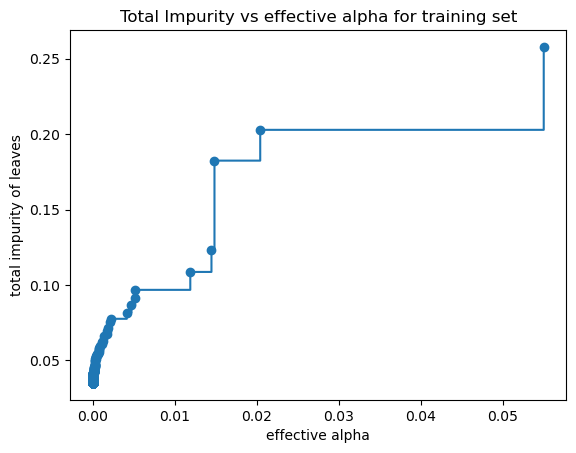

In [128]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

In [130]:
filtered_ccp_alphas = [value for value in ccp_alphas if value > 0.001]

print(filtered_ccp_alphas)

[0.0010618663916845718, 0.0011327969902744884, 0.0012027144924619234, 0.0013817931387553554, 0.0017265895971851444, 0.0017840205617367286, 0.0018824232673147912, 0.002045323139489065, 0.00216476617121641, 0.004144318535765088, 0.004714801699214897, 0.00516160037434267, 0.005163943470951445, 0.011883252448083869, 0.014463785239770217, 0.01483104681808739, 0.02040856154149242, 0.054972351364731206, 0.20280392360890692]


In [131]:
clfs = []
for ccp_alpha in filtered_ccp_alphas:
    clf = tree.DecisionTreeClassifier(random_state=0, ccp_alpha=abs(ccp_alpha))
    clf.fit(X_train, y_train)
    clfs.append(clf)
print(
    "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
        clfs[-1].tree_.node_count, filtered_ccp_alphas[-1]
    )
)

Number of nodes in the last tree is: 1 with ccp_alpha: 0.20280392360890692


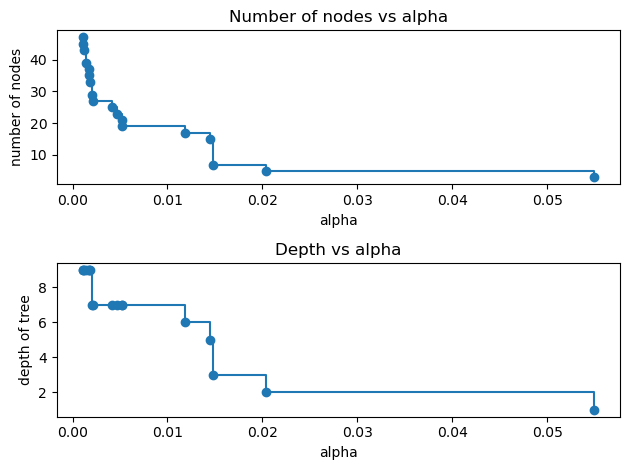

In [132]:
clfs = clfs[:-1]
ccp_alphas = filtered_ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

In [133]:
y_test_preds = [clf.predict(X_test) for clf in clfs]


In [134]:
y_train['Label'].values

array([1, 0, 0, ..., 0, 1, 0], dtype=int64)

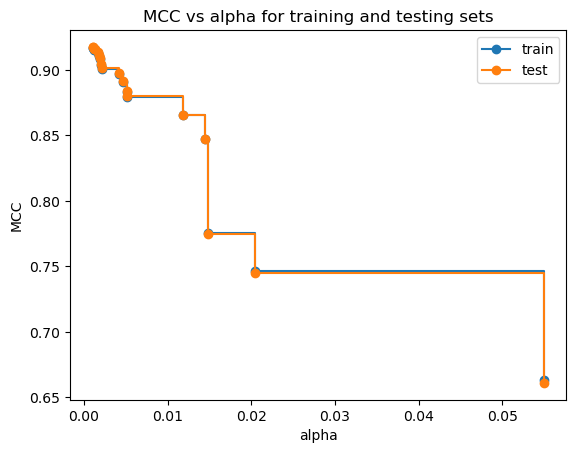

In [135]:
y_train_preds = [clf.predict(X_train) for clf in clfs]
y_test_preds = [clf.predict(X_test) for clf in clfs]

# Calculate MCC for each classifier on the training data
train_scores = [matthews_corrcoef(y_train['Label'].values, y_train_pred) for y_train_pred in  y_train_preds]
test_scores = [matthews_corrcoef(y_test['Label'].values, y_test_pred) for y_test_pred in  y_test_preds]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("MCC")
ax.set_title("MCC vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()

### X_A_chi2_40

In [96]:
X_train, X_test, y_train, y_test = train_test_split(datasets['X_A_chi2_40'], y_b,test_size=0.2,  random_state=0)

clf = tree.DecisionTreeClassifier(random_state=0)
path = clf.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

Text(0.5, 1.0, 'Total Impurity vs effective alpha for training set')

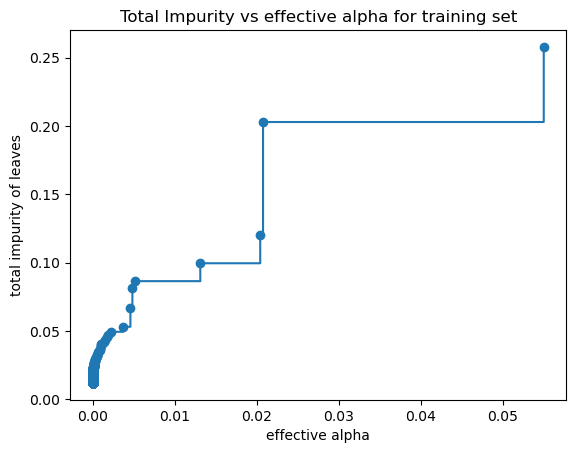

In [98]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(ccp_alphas[:-1], impurities[:-1], marker="o", drawstyle="steps-post")
ax.set_xlabel("effective alpha")
ax.set_ylabel("total impurity of leaves")
ax.set_title("Total Impurity vs effective alpha for training set")

In [99]:
filtered_ccp_alphas = [value for value in ccp_alphas if value > 0.01]

print(filtered_ccp_alphas)

[0.013103071906996402, 0.020408561541492405, 0.020753199359133973, 0.05497235136473119, 0.2028039236089071]


In [104]:
clfs = []
for ccp_alpha in filtered_ccp_alphas:
    clf = tree.DecisionTreeClassifier(random_state=0, ccp_alpha=abs(ccp_alpha))
    clf.fit(X_train, y_train)
    clfs.append(clf)
print(
    "Number of nodes in the last tree is: {} with ccp_alpha: {}".format(
        clfs[-1].tree_.node_count, filtered_ccp_alphas[-1]
    )
)

Number of nodes in the last tree is: 1 with ccp_alpha: 0.2028039236089071


ValueError: x and y must have same first dimension, but have shapes (4,) and (3,)

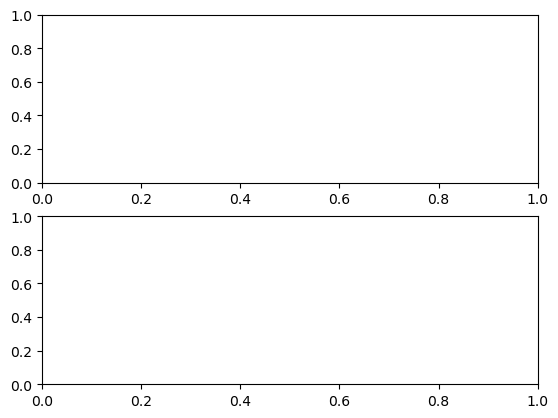

In [102]:
clfs = clfs[:-1]
ccp_alphas = filtered_ccp_alphas[:-1]

node_counts = [clf.tree_.node_count for clf in clfs]
depth = [clf.tree_.max_depth for clf in clfs]
fig, ax = plt.subplots(2, 1)
ax[0].plot(ccp_alphas, node_counts, marker="o", drawstyle="steps-post")
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("number of nodes")
ax[0].set_title("Number of nodes vs alpha")
ax[1].plot(ccp_alphas, depth, marker="o", drawstyle="steps-post")
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("depth of tree")
ax[1].set_title("Depth vs alpha")
fig.tight_layout()

ValueError: x and y must have same first dimension, but have shapes (4,) and (3,)

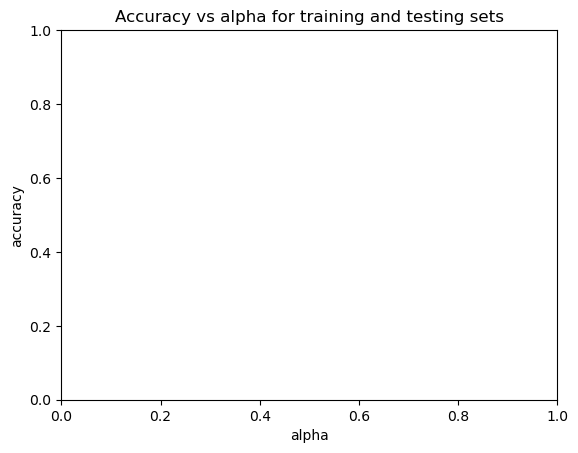

In [103]:
train_scores = [clf.score(X_train, y_train) for clf in clfs]
test_scores = [clf.score(X_test, y_test) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("Accuracy vs alpha for training and testing sets")
ax.plot(ccp_alphas, train_scores, marker="o", label="train", drawstyle="steps-post")
ax.plot(ccp_alphas, test_scores, marker="o", label="test", drawstyle="steps-post")
ax.legend()
plt.show()